In [ ]:
#https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb

Deep Learning in Genomics Primer (Tutorial)
This tutorial is a supplement to the manuscript, A Primer on Deep Learning in Genomics (Nature Genetics, 2018) by James Zou, Mikael Huss, Abubakar Abid, Pejman Mohammadi, Ali Torkamani & Amalio Telentil. Read the accompanying paper here:
https://www.nature.com/articles/s41588-018-0295-5




 Our goal is to build a classifier that can predict whether a particular sequence will bind to the protein
 and discover the short motif that is the binding site in the sequences that are bound to the protein.

1. Curate the Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

SEQUENCES_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

sequences = requests.get(SEQUENCES_URL).text.split('\n')
sequences = list(filter(None, sequences))  # This removes empty sequences.

# Let's print the first few sequences.
pd.DataFrame(sequences, index=np.arange(1, len(sequences)+1), 
             columns=['Sequences']).head()
     


,Sequences
1,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...
2,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...
3,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...
4,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...
5,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...


By processing this data, the network will learn to distinguish sequences that bind to the transcription factor 
from those that do not. We will split the data into three different sub-datasets:
train
validation
test

The next step is to organize the data into a format that can be passed into a deep learning algorithm. Most deep learning algorithms accept data in the form of vectors or matrices (or more generally, tensors).

To get each DNA sequence in the form of a matrix, we use one-hot encoding, which encodes every base in a sequence in the form of a 4-dimensional vector, with a separate dimension for each base. We place a "1" in the dimension corresponding to the base found in the DNA sequence, and "0"s in all other slots. We then concatenate these 4-dimensional vectors together along the bases in the sequence to form a matrix.

In the cell below, we one-hot encode the simulated DNA sequences, and show an example of what the one-hot encoded sequence looks like:



In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

for sequence in sequences:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

np.set_printoptions(threshold=40)
input_features = np.stack(input_features)
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',sequences[0][:10],'...',sequences[0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 CCGAGGGCTA ... CGCGGACACC
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 1. 0. 0.]
 [1. 1. 0. ... 0. 1. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Similarly, we can go ahead and load the labels (response variables). In this case, the labels are structured as follows: a "1" indicates that a protein bound to the sequence, while a "0" indicates that the protein did not. While we could use the labels as a vector, it is often easier to similarly one-hot encode the labels, as we did the features. We carry out that here:


In [7]:
LABELS_URL = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

labels = requests.get(LABELS_URL).text.split('\n')
labels = list(filter(None, labels))  # removes empty sequences

one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)
     


Labels:
 [['0' '0' '0' ... '0' '1' '1']]
One-hot encoded labels:
 [[1. 1. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 1.]]


We also go ahead and split the data into training and test sets. The purpose of the test set is to ensure that we can observe the performance of the model on new data, not seen previously during training. At a later step, we will further partition the training set into a training and validation set.

In [8]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels, test_size=0.25, random_state=42)


2. Select the Architecture and Train

In [9]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv1D(filters=32, kernel_size=12, 
                 input_shape=(train_features.shape[1], 4)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', 
              metrics=['binary_accuracy'])
model.summary()

2023-11-14 13:35:32.190479: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 13:35:38.804274: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 39, 32)            1568      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 288)               0         
                                                                 
 dense (Dense)               (None, 16)                4624      
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 6,226
Trainable params: 6,226
Non-trainable params: 0
______________________________________________________

Once the loss for the validation set stops improving or gets worse throughout the learning cycles, it is time to stop training because the model has already converged and may be just overfitting.


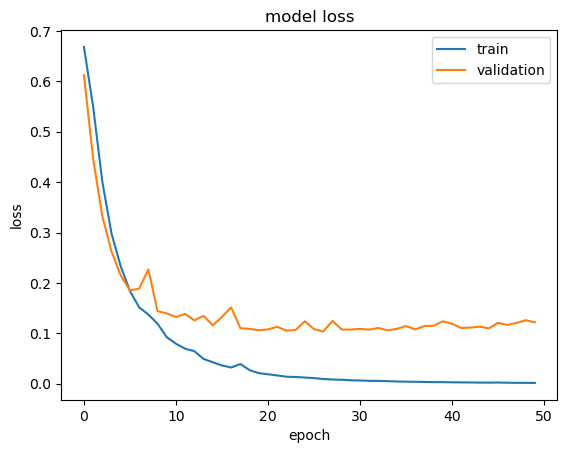

In [10]:
history = model.fit(train_features, train_labels, 
                    epochs=50, verbose=0, validation_split=0.25)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

Similarly, we can plot the accuracy of our neural network on the binary classification task. The metric used in this example is the binary accuracy, which calculates the proportion of predictions that match labels or response variables.

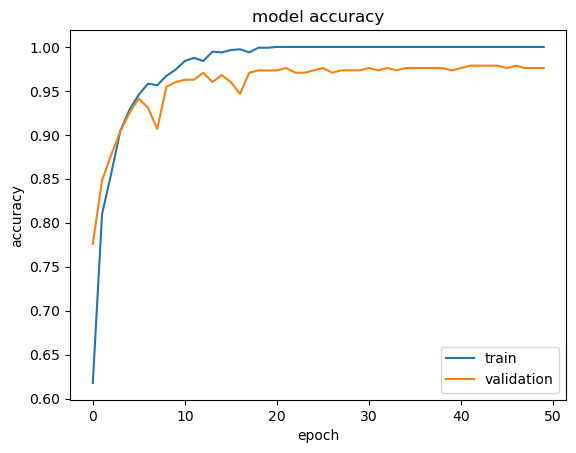

In [11]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

The best way to evaluate whether the network has learned to classify sequences is to evaluate its performance on a fresh test set consisting of data that it has not observed at all during training. Here, we evaluate the model on the test set and plot the results as a confusion matrix. Nearly every test sequence should be correctly classified.

3. Evaluate

16/16 [==============================] - 0s 1ms/step
Confusion matrix:
 [[246  13]
 [  1 240]]


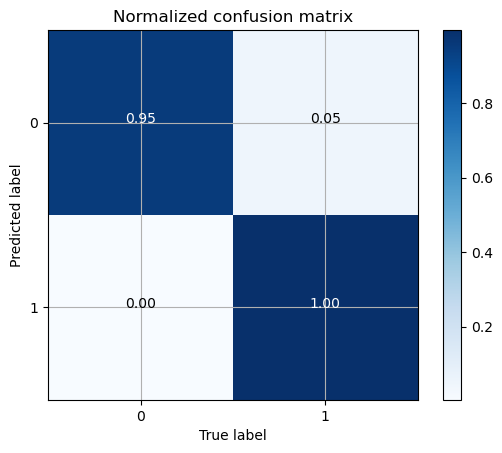

In [12]:
from sklearn.metrics import confusion_matrix
import itertools

predicted_labels = model.predict(np.stack(test_features))
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Normalized confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks([0, 1]); plt.yticks([0, 1])
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')